In [1]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm

In [2]:
conf = {
    'bs':180,
    'emb_size':256,
    'arch':resnet34,
    'split':0
}

In [3]:
PATH = Path('../input/shopee-product-matching')

In [4]:
train_df = pd.read_csv(PATH/'train.csv')

In [5]:
def hash_label(x):
    x = (13*x)%10000
    return x // 2000
train_df['split']=train_df.label_group.apply(hash_label)
train_df['is_valid'] = train_df.split==conf['split']

In [6]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

In [7]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 #get_x=ColReader('image', pref=PATH/'train_images'),
                 get_x=get_img_file,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls = data_block.dataloaders(train_df, bs=conf['bs'], num_workers=2)

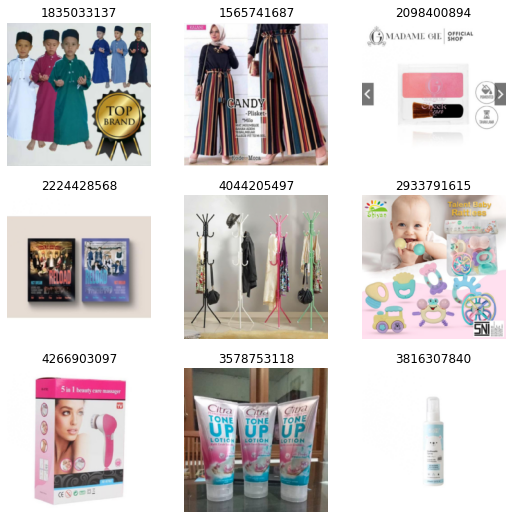

In [8]:
dls.valid.show_batch()

In [10]:
!ls ../input/resnet-model

resnet34.pth


In [14]:

learn = cnn_learner(dls,conf['arch'], pretrained=False,path='../input', model_dir='resnet-model')

In [17]:
model_file  = '../input/resnet-model/resnet34.pth'
state = torch.load(model_file)['model']
learn.model.load_state_dict(state, strict=True)

<All keys matched successfully>

In [ ]:
def embs_from_resnet(model, dl):
    model_stem =list(learn.model.children())[0].eval()
    pipeline = nn.Sequential(model_stem, AdaptiveConcatPool2d(), Flatten())
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = pipeline(bx)
            all_embs.append(embs.half())
        all_ys.append(by)
    return torch.cat(all_embs), torch.cat(all_ys)

In [ ]:
def emb_sim(inp):
    normal_inp=F.normalize(inp)
    return normal_inp @ normal_inp.T

In [ ]:
def groups_from_embs(x, treshold=0.9):
    sims = emb_sim(x)
    preds_groups=[]
    for i in range(len(sims)):
        tops= torch.where(sims[i]>treshold)[0]
        preds_groups.append(tops)
    return preds_groups

In [ ]:
def f1_score(pred_groups, real_groups):
    res =0
    for pred, real in zip(pred_groups, real_groups):
        #print(pred, real)
        inter = set(pred.tolist()).intersection(set(real.tolist()))
        #print(inter)
        res += 2 * len(inter) / (len(pred)+len(real))
    return res / len(pred_groups)

In [ ]:
def groups(preds):
    matches = preds[:,None]==preds[None,:]
    groups = [torch.where(matches[i])[0] for i in range(len(matches))]
    return groups

In [ ]:
# %%time
# embs, y = embs_from_resnet(learn.model.cuda(), dls.valid)

# emb_groups = groups_from_embs(embs)
# emb_groups[:5]

# real_groups = groups(y)

# f1_score(emb_groups, real_groups)

In [ ]:
fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title']]
fake_test_df = pd.concat([fake_test_df, fake_test_df])
fake_test_df.head()

In [ ]:
test_df = pd.read_csv(PATH/'test.csv')
#test_df = fake_test_df

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
embs, _ = embs_from_resnet(learn.model.cuda(), test_dl)

In [ ]:
emb_groups = groups_from_embs(embs)

In [ ]:
def matches(group, data):
    return ' '.join([data.iloc[x.cpu().item()].posting_id for x in group])

In [ ]:
m = [matches(g, test_df) for g in emb_groups]

In [ ]:
test_df['matches']=m

In [ ]:
test_df[['posting_id','matches']].to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()